In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import numpy as np
import math
import matplotlib.patches as patches
from IPython.display import HTML

%pylab inline
plt.style.use('dark_background')
pylab.rcParams['figure.figsize'] = (10.0, 6.0)

Populating the interactive namespace from numpy and matplotlib


# Euler Integration

In [2]:
def simulate(Δt,z,u):
    z = z + Δt*u
    return z


#  Trajectory Functions

In [4]:
def control(t):
    ### WRITE YOUR CONTROL POLICY HERE:
    ux = 20*math.sin(t)
    uz = 20*math.cos(t)*math.sin(t)
    dx = t/10
    dz = t/10
    ddx = t/100
    ddz = t/100
    theta_x = t
    theta_dx = t/100
    theta_ddx = t/1000
    
    return np.array([ux, uz, dx, dz, ddx, ddz, theta_x, theta_dx, theta_ddx])

In [6]:
tf=10
Δt = 0.1  #Time Step
time = np.linspace(0.,tf,int(tf/Δt+1))

u = np.array([0,0,0,0,0,0,0,0,0])
u_log = [np.copy(u)]
for t in time:
    u = control(t)
    u_log.append(np.copy(u))
u_log = np.array(u_log)
#deleted one row to make things equal eachother
u_del = np.delete(u_log,0,0)

# Plotting 

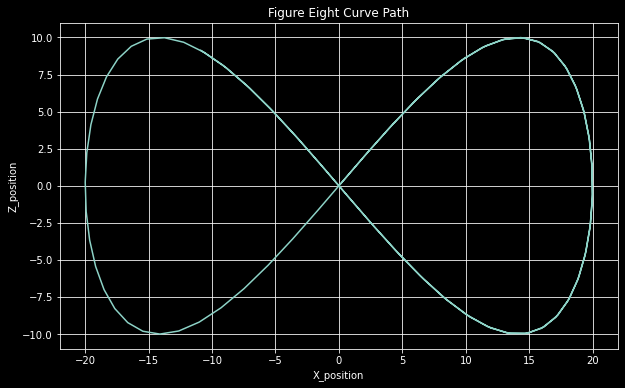

In [7]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
plt.title('Figure Eight Curve Path')
plt.xlabel('X_position')
plt.ylabel('Z_position')
plt.grid()
ax1.plot(u_del[:,0],u_del[:,1])

# Creating The Vehicle

In [8]:
p1 = np.array([-2,0.5])
p2 = np.array([0,1])
p3 = np.array([2,0.5])
theta1 = 135
theta2 = 90
theta3 = 45

A = np.array([[math.cos(theta1),math.cos(theta2),math.cos(theta3)],[math.sin(theta1),math.sin(theta2),math.sin(theta3)],[math.cos(theta1)*p1[1]-math.sin(theta1)*p1[0],math.cos(theta2)*p2[1]-math.sin(theta3)*p3[0],math.cos(theta3)*p3[1]-math.sin(theta3)*p3[0]]])
print(A)
rank = np.linalg.matrix_rank(A)
print("The rank of the matrix is: ",rank)

[[-0.99608784 -0.44807362  0.52532199]
 [ 0.08836869  0.89399666  0.85090352]
 [-0.32130655 -2.14988067 -1.43914605]]
The rank of the matrix is:  3


In [9]:
x_1 = u_del[:,0]
z_1 = u_del[:,1]
dx_1 = u_del[:,2]
dz_1 = u_del[:,3]
ddx_1 = u_del[:,4]
ddz_1 = u_del[:,5]
theta_x_1 = u_del[:,6]
theta_dx_1 = u_del[:,7]
theta_ddx_1 = u_del[:,8]


#Initialization
z = np.array([0.,0.,0.,0.,0.,0.])
#print(z)
z_log = [np.copy(z)]
dz = np.array([0.,0.,0.,0.,0.,0.])
r=1
g=9.8
mass = 1
kp_kd = np.array([10,5])

# Following the Trajectory

In [10]:
for t in range(len(time)-1):
    xu = kp_kd[0]*(x_1[t+1]-z[0]) + kp_kd[1]*(dx_1[t+1]-z[3]) + ddx_1[t+1]
    zu = ((kp_kd[0]*(z_1[t+1]-z[1]) + kp_kd[1]*(dz_1[t+1]-z[4]) + mass*g)/mass-g) + ddz_1[t+1]
    thetaU = (kp_kd[0]*(theta_x_1[t+1]-z[2]) + kp_kd[1]*(theta_dx_1[t+1]-z[5]))*(1/2*mass*r**2)+theta_ddx_1[t+1]
    wrench = np.array([xu,zu,thetaU])

    rotation = [[math.cos(theta_x_1[t]),math.sin(theta_x_1[t]),0],[math.sin(-theta_x_1[t]), math.cos(theta_x_1[t]),0],[0,0,1]]
    world_frame = np.dot(rotation,A)
    inv = np.linalg.inv(world_frame)
    u = np.dot(inv,wrench)
    
    a = np.dot(world_frame,u)
    dz[:3] = z[3:]
    dz[3:] = a

    z = simulate(Δt,z,dz)
    z_log.append(np.copy(z))
z_log = np.array(z_log)


pos_x = z_log[:,0]
#print(pos_x)
pos_z = z_log[:,1]
#print(pos_z)
pos_theta = z_log[:,2]


# Animation

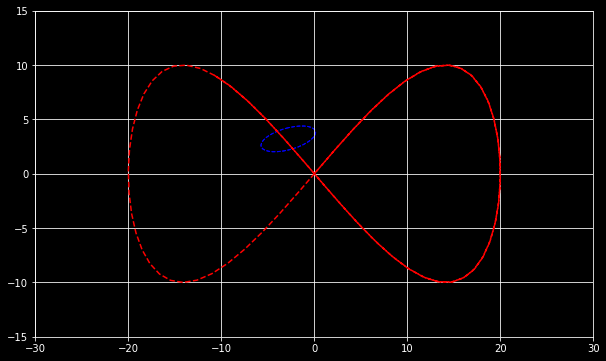

In [11]:
fig, ax = plt.subplots()

q_x = [-2, 0,2]
q_z = [0.5,1,0.5]
x_direct = [-1,0,1]
z_direct = [1,1,1]



ax.set_xlim(-30, 30)
ax.set_ylim(-15, 15)
ax.plot(u_del[:,0],u_del[:,1], 'r--')
plt.grid()

patch = patches.Ellipse((5,0),0,0,ec='b',fc='none',ls='--')


def init():
    ax.add_patch(patch)
    return patch,


def animate(i):
    patch.set_width(-6)
    patch.set_height(2)
    patch.set_center([pos_x[i], pos_z[i]])
    #patch.set_xy([0,0])
    patch.angle = np.rad2deg(pos_theta[i])
    return patch,

anim = animation.FuncAnimation(fig, animate,init_func=init,frames=len(time),interval=150,blit=True)

HTML(anim.to_jshtml())